# Tutorial 'QC, topographical analysis and segmentaton-free of Spot-based transcriptomics data'


This tutorial was made to showcase the ISS analysis workflow at our group, which is based on a segmentation-free mindset. It makes use of a python package called 'planktonpy', in which I collected functinalities of past analysis projects for others to use. Is strongly inspired by the *squidpy* package, but targeted especially at the topographical analysis of spot-based data.

In [1]:
%load_ext autoreload
%autoreload 2

## Make screen wider, add planktonpy folder to system path to enable import:

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
import os

sys.path.append(os.path.join(os.path.abspath('.'),'../..'))

### data import:

In [2]:
import plankton.plankton as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def figure(width=6,height=6):
    plt.figure(figsize=(width,height))


### Coordinates are loaded as a pd.DataFrame:

In [3]:
um_p_px = 0.325

# Read coordinate/gene data from .csv file
coordinates = pd.read_csv('./data/S2T1_pcw6.csv')
coordinates

Gene  Global_y_pos  Global_x_pos            Q   parentCell
0        FLT1   4909.911982   1190.493724  1190.493724  1190.493724
1        FLT1   4908.912407   1194.492023  1194.492023  1194.492023
2        JAG2   4852.936212   1614.313488  1614.313488  1614.313488
3       RSPO2   4940.898805   1634.304986  1634.304986  1634.304986
4       SPRY1   4982.880951   1759.251850  1759.251850  1759.251850
...       ...           ...           ...          ...          ...
494144    MET  11432.138303   9209.083692  9209.083692  9209.083692
494145  FGFR4  10289.624175   9292.048410  9292.048410  9292.048410
494146  FGFR4  11295.196539   9343.026730  9343.026730  9343.026730
494147   DTX1  13125.418209   9475.970194  9475.970194  9475.970194
494148   ETV1  13123.419059   9476.969769  9476.969769  9476.969769

[494149 rows x 5 columns]

### For reference during analysis, I found it very handy to have a stain image at hand:

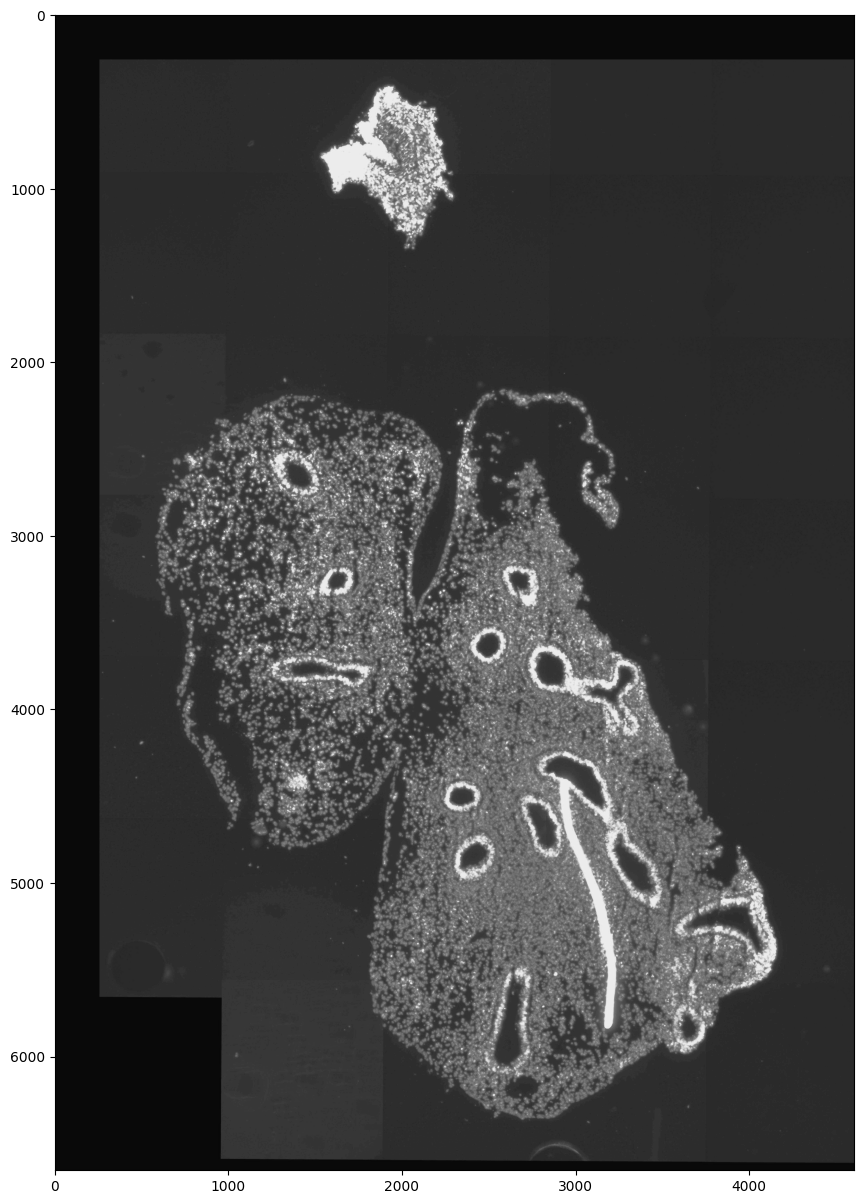

In [4]:
# Load staining image as .jpg:

bg = -plt.imread('./data/background.jpg').mean(-1)
bg = (bg-bg.min())/(bg.max()-bg.min())

plt.imshow(bg,cmap='Greys')

### To make life easier, we can extract (x,y) coordinates and gene labels from the data frame:

In [5]:
# rands = np.random.rand(5000,2,)*np.array([coordinates.Global_x_pos.values.max(),coordinates.Global_y_pos.values.max()])

# x = np.hstack([coordinates.Global_x_pos.values,rands[:,0]])
# y = np.hstack([coordinates.Global_y_pos.values,rands[:,1]])

# rand_genes = coordinates.Gene.values[np.random.randint(len(coordinates.Gene.unique()), size=(rands.shape[0]))]
# g = np.hstack([coordinates.Gene.values,rand_genes])
# g = np.hstack([coordinates.Gene.values,['noise']*rands.shape[0]])

x =  coordinates.Global_x_pos.values 
y =  coordinates.Global_y_pos.values 

g =  coordinates.Gene.values



## ...and the stage is yours!

You can now create a plankton.SpatialData frame. It's a subclass of pandas.DataFrame and inherits all of its properties. There is a bit of added functionality though, and the indexing works different (namely along the vertical axis primarily):

In [6]:
# Create a plankton-SpatialData object with the coordinates:

sdata = pl.SpatialData(
                        coordinates.Gene,
                        coordinates.Global_x_pos*um_p_px,
                        coordinates.Global_y_pos*um_p_px,
                        )

#show HTML representation:
sdata

g            x            y  gene_id
0        FLT1   386.910460  1595.721394       47
1        FLT1   388.209908  1595.396532       47
2        JAG2   524.651884  1577.204269       69
3       RSPO2   531.149120  1605.792112      107
4       SPRY1   571.756851  1619.436309      120
...       ...          ...          ...      ...
494144    MET  2992.952200  3715.444948       81
494145  FGFR4  3019.915733  3344.127857       46
494146  FGFR4  3036.483687  3670.938875       46
494147   DTX1  3079.690313  4265.760918       25
494148   ETV1  3080.015175  4265.111194       32

[494149 rows x 4 columns]

### sdata comes with a few indicators for free, some of which are listed in the gene-centric 'stats' property:

In [7]:
# inspect 'stats' info frame:

sdata.stats

counts  count_ranks  count_indices  gene_ids
AP000561     656           24            138         0
ARIH1       9550          132             10         1
ATP11A      2449           71             24         2
BCL2        3734           97            137         3
BMP5       13684          138             25         4
...          ...          ...            ...       ...
WNT2         114            3             89       137
WNT2B         17            0              4       138
WNT5A        792           30             88       139
WNT7B        993           35             13       140
WT1         2632           78              9       141

[142 rows x 4 columns]

<AxesSubplot:>

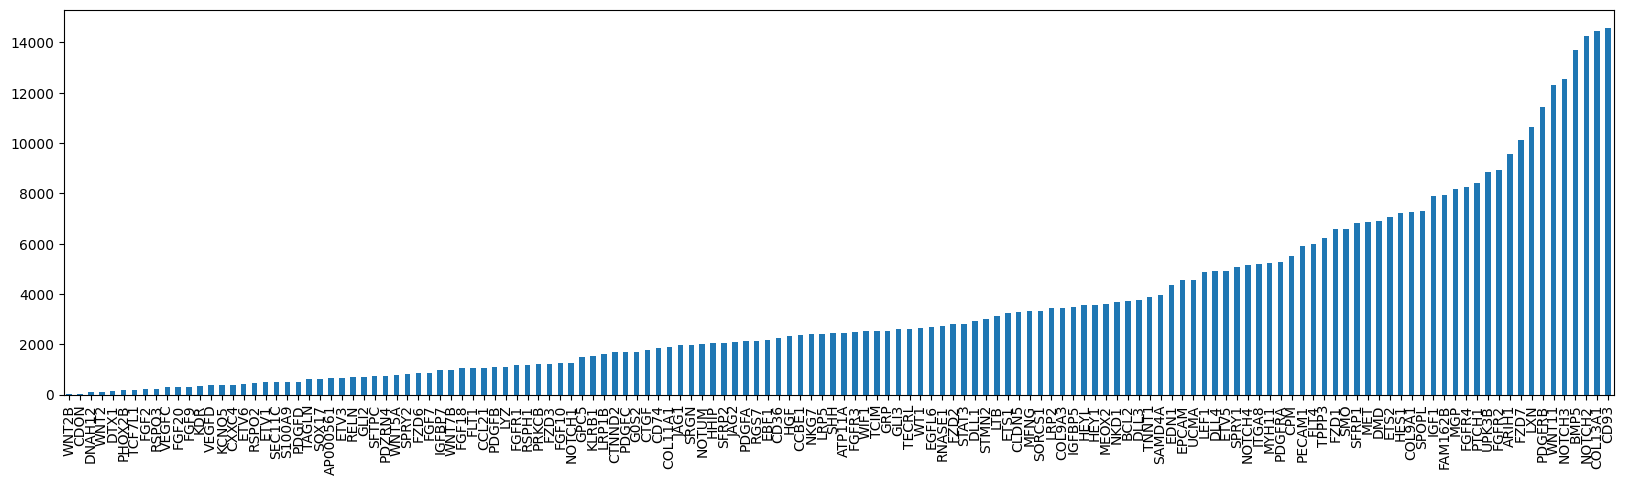

In [8]:
# Plot a representation of the gene counts in the data set:

figure(20,5)
sdata.counts.sort_values().plot.bar()

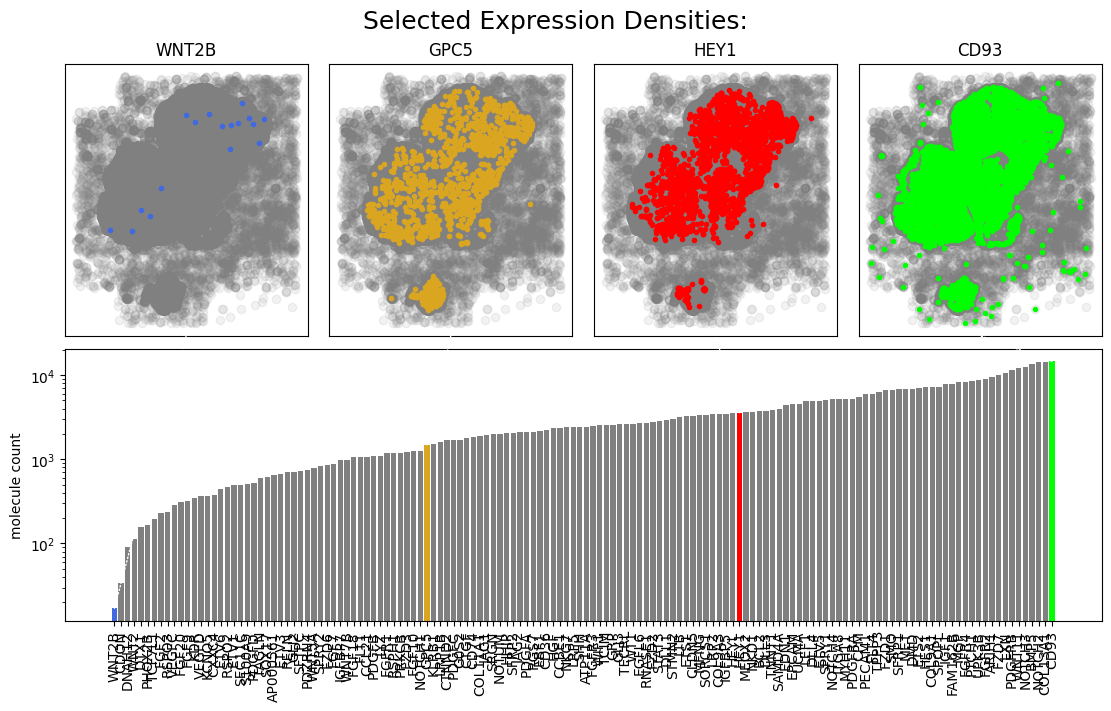

In [9]:
# Plot 'overview/summary' data set :
sdata.plot_overview()

(<matplotlib.collections.PathCollection at 0x7f69d23cb910>, None, None)

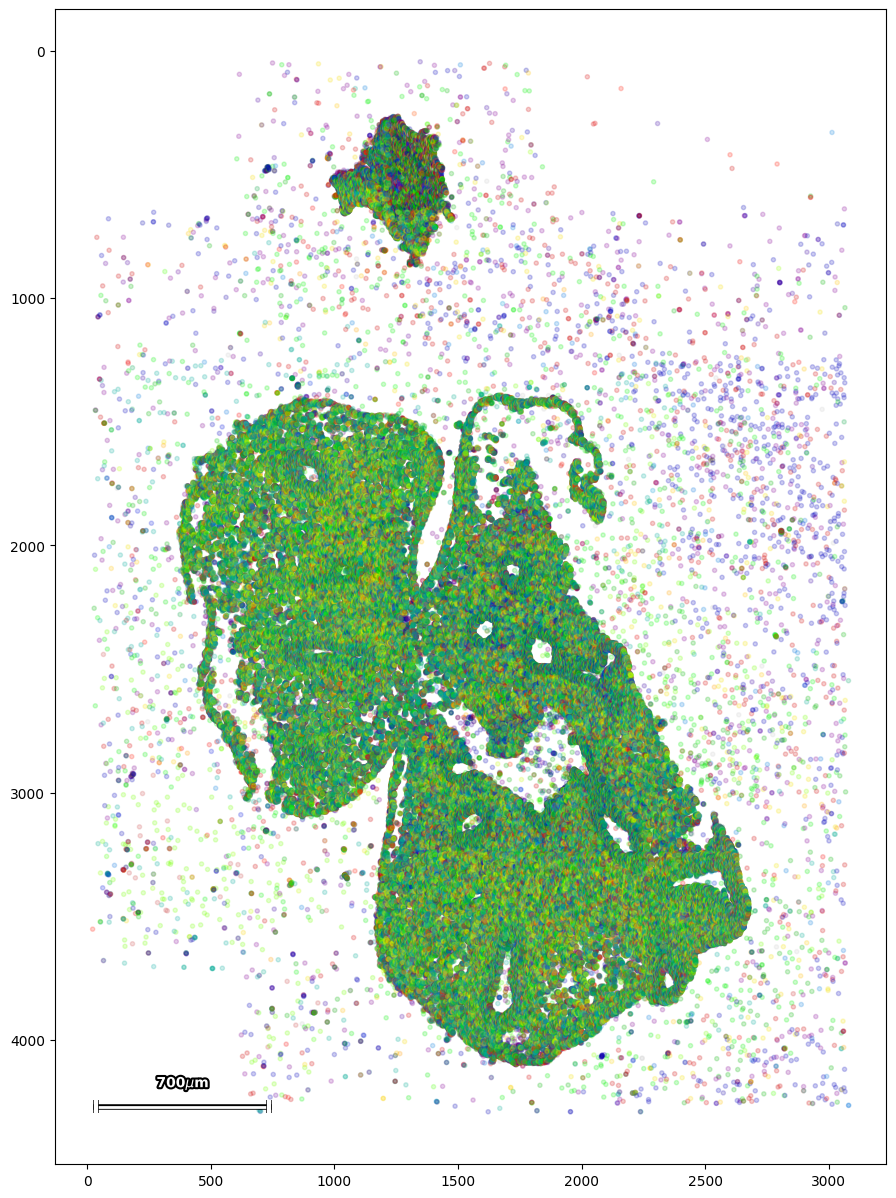

In [10]:
# use the 'scatter' function to get familiar with the data set:

plt.figure(figsize=(15,15))

sdata.scatter(alpha=0.2)

#### Adding a pixel map as background image:

We can create a PixelMap object to integrate the spot-based molecule coordinates and the pixel/grid based image data:

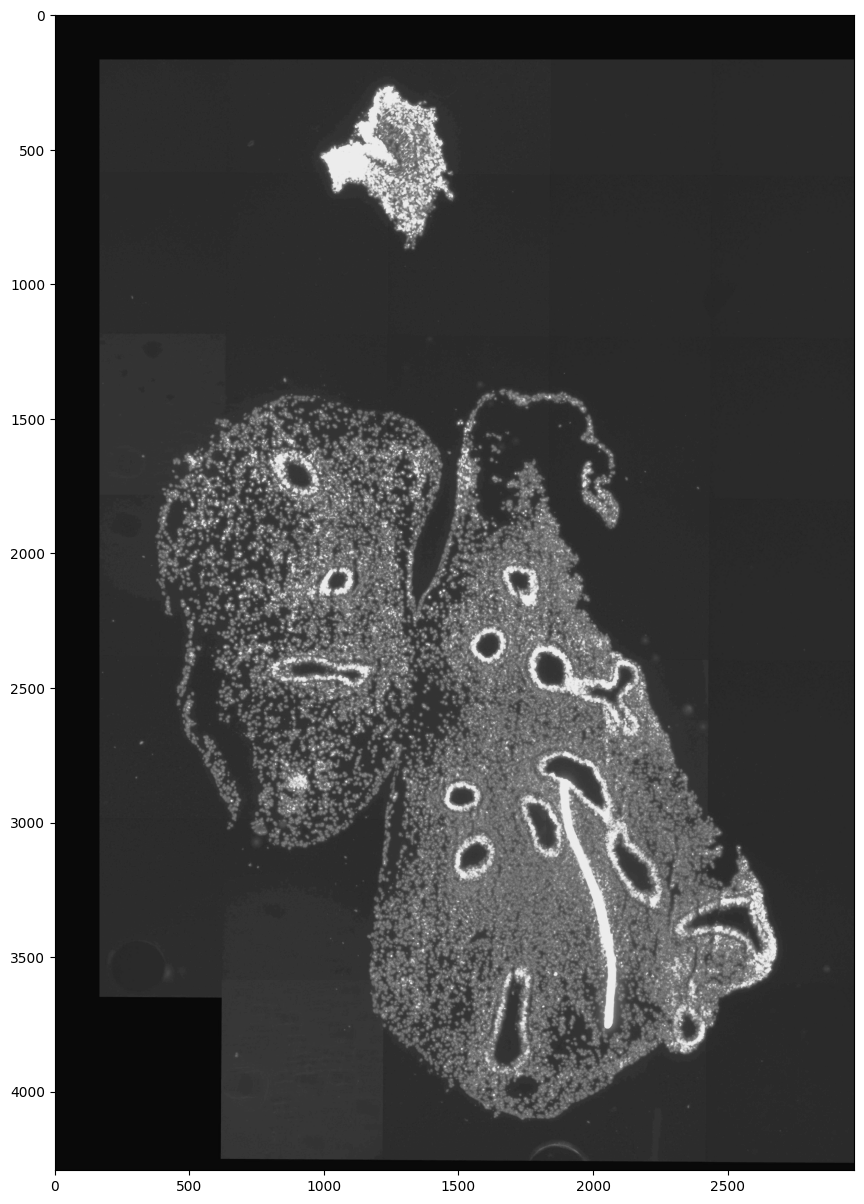

In [11]:
bg_map = pl.PixelMap(pixel_data=bg,
                     cmap='Greys',
                     px_p_um = 0.504/um_p_px)
bg_map.imshow()


... and feed the pixel map to sdata during creation:

In [12]:
sdata = pl.SpatialData(
                        coordinates.Gene,
                        coordinates.Global_x_pos*um_p_px,
                        coordinates.Global_y_pos*um_p_px,
                        pixel_maps={'DAPI':bg_map}
                        )

### The scatter plots now automatically contain a plot background:

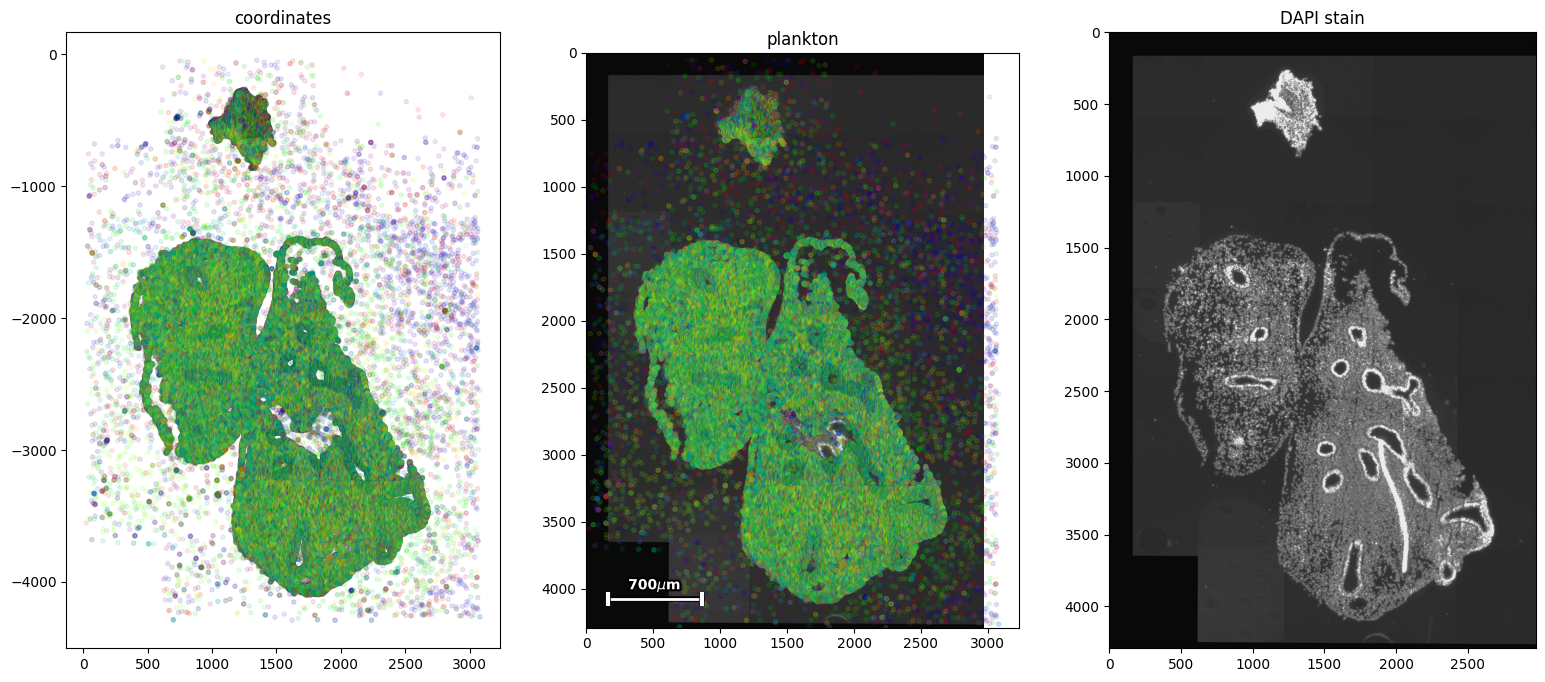

In [13]:
plt.figure(figsize=(19,8))

plt.subplot(1,3,1)
plt.title('coordinates')
plt.scatter(*sdata.coordinates[:,:].T*np.array([[1],[-1]]),c=sdata.var.c_genes[sdata.gene_ids],marker='.',alpha=0.1)

plt.subplot(1,3,2)
plt.title('plankton')
sdata.scatter(alpha=0.1)

ax=plt.subplot(1,3,3)
plt.title('DAPI stain')
bg_map.imshow(axd=ax)

#### basic slicing functionality:

(<matplotlib.collections.PathCollection at 0x7f69d1b610c0>, None, None)

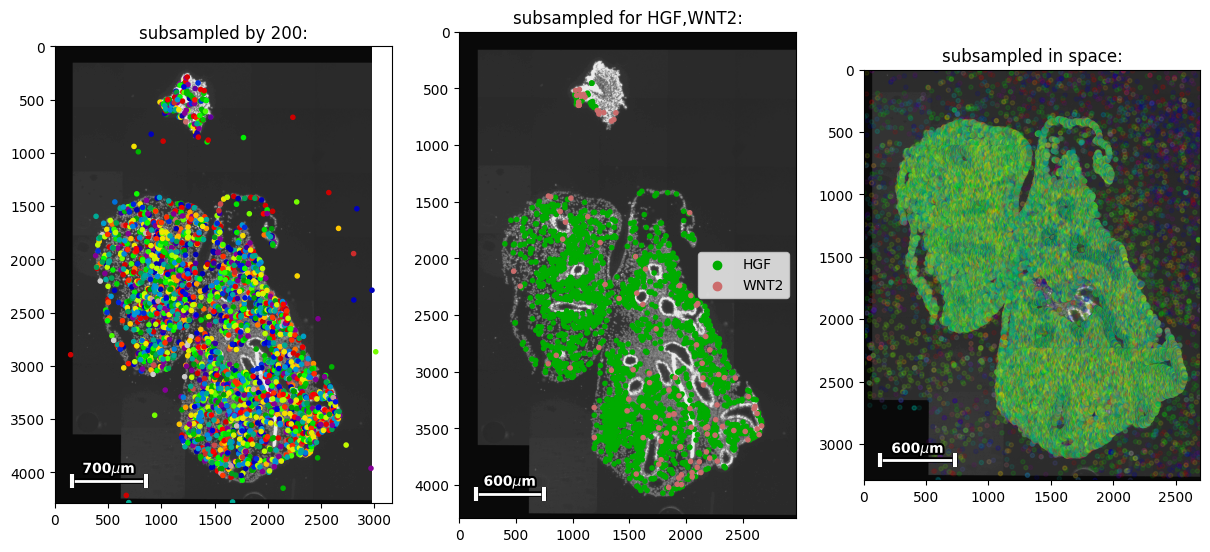

In [14]:
plt.figure(figsize=(20,7))


# Slice using array notation:
plt.subplot(1,4,1)
plt.title('subsampled by 200:')
sdata[::200].scatter()

# Subsample using boolean mask:
plt.subplot(1,4,2)
plt.title('subsampled for HGF,WNT2:')
sdata[sdata.g.isin(['HGF','WNT2'])].scatter(legend=True)

# Subsample using spatial view:
plt.subplot(1,4,3)
plt.title('subsampled in space:')
sdata.spatial[100:2800,1000:].scatter(alpha=0.1)


## Task:

use sdata.counts and sdata.gene_ids-indexing to plot all genes that occur below 200 times in the sample:

(<matplotlib.collections.PathCollection at 0x7f69d23eba30>,
 None,
 <matplotlib.legend.Legend at 0x7f69ce32b220>)

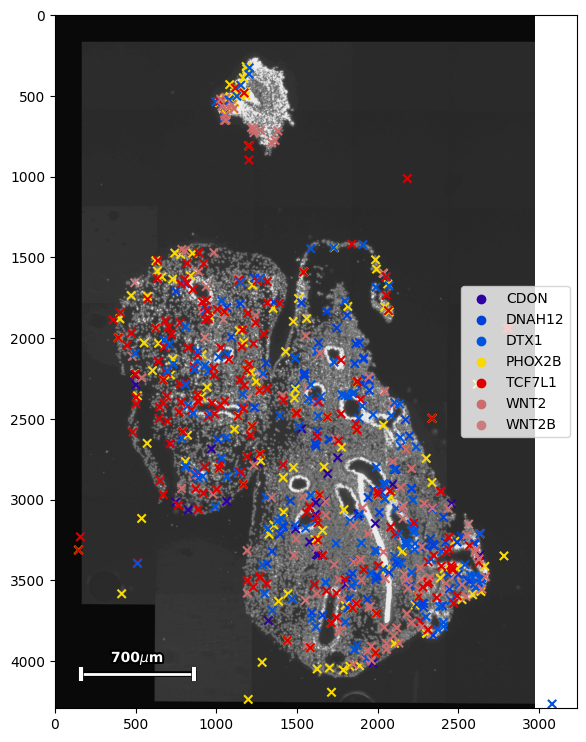

In [15]:
figure(9,9)
sdata[(sdata.counts<200)[sdata.gene_ids]].scatter(marker='x',legend=True)

# Supervised analysis:

Often, larger scale projects follow a multi-omics approach where external expression data is available for analysis. We can make use of this external data for quality control and to perform supervized analysis:

In [17]:
# 'cheat-create' an anndata set:

pci = pd.read_csv('./data/S2T1_pcw6_complex_celltypes_formatted.csv',index_col=0)
import anndata

cts = pci['cell type'].unique()
cts = [c[:-1] if c[-1]==' ' else c for c in cts]
cts = sorted(pd.Series([c[:-2] if c[-1].isdigit() else c for c in cts]).unique())
# cts

signatures = pd.DataFrame(columns=cts,index=pci.columns[78:])


for c in cts:
    kewl = pci[pci['cell type'].str.contains(c)]
    signatures[c] = kewl.iloc[:,78:].mean(0)
    

adata = anndata.AnnData(signatures.T)
adata.X = np.array(np.nan_to_num(signatures.T))
adata.obs['celltype'] = adata.obs.index


# pl.ScanpyDataFrame(sdata,adata)

/tmp/ipykernel_69920/1940670195.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(signatures.T)


An AnnData object can be passed during initialization, which is then integrated with the spatial data set. Genes that do not occur in both data sets are removed, and sdata.clean() removes the empty gene categories from the statistics/var list:

In [19]:
sdata = pl.SpatialData(
                        coordinates.Gene,
                        coordinates.Global_x_pos*um_p_px,
                        coordinates.Global_y_pos*um_p_px,
#                         pixel_maps={'DAPI':bg_map},
                        scanpy=adata
                        )

sdata = sdata.clean()

In [20]:
sdata.scanpy

For quality control, we can compare count distributions between the two modalities:

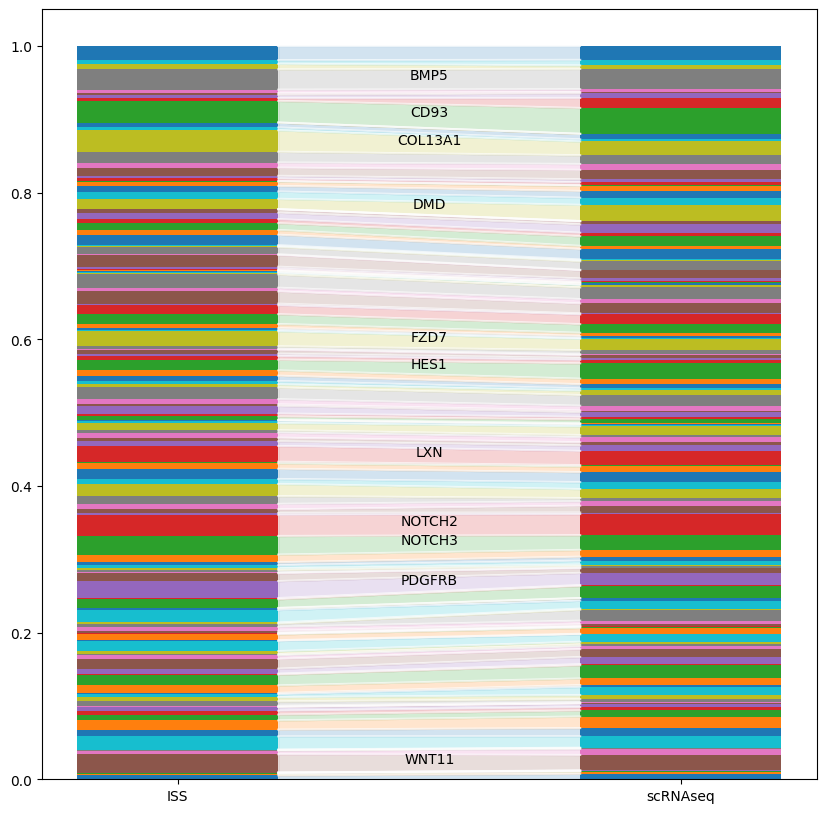

In [21]:
from plankton.utils import hbar_compare

figure(10,10)
hbar_compare(sdata.stats,sdata.scanpy.stats,['ISS','scRNAseq'])



In the next step, it is necessary to generate a signature matrix from the available expression data.
The matrix should contain a single correlation indicator for each gene <-> celltype pair:

In [22]:
signatures = sdata.scanpy.generate_signatures()

signatures[signatures.isna()]=0

signatures.to_csv('signatures.csv')


signatures

/home/sebastian/anaconda3/envs/plankton-tutorial/lib/python3.10/site-packages/plankton/plankton.py:101: RuntimeWarning: invalid value encountered in true_divide
  self.signature_matrix = self.signature_matrix / self.signature_matrix.std(


ARIH1    ATP11A      BCL2      BMP5  \
Adventitial fibroblast             2.675679 -0.127429 -0.219334 -0.219334   
Aimmature ASM                      0.785320 -0.311018  0.560430  0.869654   
Airway fibroblast                  1.267024 -0.211620 -0.016188  2.889475   
Airway smooth muscle (ASM)         0.000000  0.000000  0.000000  0.000000   
Arterial                           1.140750 -0.508181 -0.395754  0.541138   
B-cell                            -0.455779 -0.455779 -0.455779  1.511513   
Bronchial endothelial              1.868349 -0.210379 -0.231166  1.411029   
CTGFhigh distal epithelial         0.677575  0.677575 -0.083685  0.373071   
Capillary                          0.205469 -0.087169 -0.331033  0.059150   
Chondroblast                       2.059299 -0.081509 -0.194183  1.383254   
Ciliated epithelial               -0.519071  0.152388 -0.519071 -0.519071   
Conventional dendritic             2.671495 -0.467512 -0.075136  1.101992   
Dendritic                         -0.325396 -0.325396 -0.325396 -0.325396   
Epithelial intermediate           -0.376096 -0.376096 -0.376096  5.611112   
Erythrocyte                        3.355311  1.125816 -0.657780  2.909412   
IL                                 2.339461  0.076243  0.642048  0.076243   
Immature ASM                       1.236868 -0.226943 -0.022009  2.144431   
Immature advenstitial fibroblast   2.726906 -0.548169  0.106846  1.853553   
Immature airway fibroblast         1.443047 -0.323844 -0.018969  3.805831   
Immature arterial                  0.215961 -0.299041 -0.106937  0.514336   
Immature endothelial               0.854285 -0.403975 -0.258791 -0.065213   
Immature macrophage                3.030655 -0.488470  0.014262 -0.488470   
Immature mesenchymal               2.257998 -0.294024  0.018469  5.070429   
Immature monocyte                 -0.511939 -0.511939 -0.511939  1.535818   
Immature venous                    1.314593 -0.294362 -0.383749  0.808070   
Lymphatic endothelial              1.325135  0.102600  0.306356  0.306356   
Lymphoid progenitor                0.666687  0.381830 -0.472742 -0.187885   
Macrophage                         2.107874  0.184183  0.271624  1.408350   
Megakaryocyte                      2.228216  0.002059 -0.385098  0.098849   
Mesothelial                        2.416850 -0.003592 -0.189780  0.324099   
Migrating dendritic                0.595864  0.595864 -0.428731 -0.428731   
Monocyte                           2.973884 -0.353182 -0.138533  2.759235   
Myeloid progenitor                 6.504615 -0.508007 -0.508007  0.493797   
NE progenitor                      0.654101  0.062894  0.062894  1.836514   
Neuroendocrine                    -0.256401  0.107551 -0.013766  2.048627   
Neuronal                           0.194583  0.778332  0.194583 -0.194583   
Neutrophil                         1.810347 -0.510189  0.263323 -0.510189   
Pericyte                           0.974663 -0.300600 -0.152536  1.648116   
Proliferating endothelial          0.391609 -0.299571 -0.221990  0.500928   
Proliferating epithelial           0.628932  0.050257 -0.316306  2.276406   
Proliferating mes.                 1.825604 -0.162491  0.344245  3.080621   
Proliferating myeloid             -0.511331  3.022870 -0.511331  0.902349   
Proliferating smooth muscle        0.696149 -0.440866  0.904526  1.695001   
Proximal progenitor                2.168933  0.007664 -0.127415  3.924963   
Proximal secretory                 0.355871 -0.326240 -0.326240  2.615362   
SFTPChigh distal                   1.313702  1.405583 -0.248274  0.532714   
SOX9high ETV5medium distal epith.  1.398469  1.951581 -0.260865  0.568802   
Venous                             1.556344 -0.403857 -0.151831  2.676458   

                                      CCBE1     CCL21      CD36      CD74  \
Adventitial fibroblast             0.791623 -0.632907 -0.403144 -0.586955   
Aimmature ASM                     -0.029906 -0.535908 -0.170462 -0.311018   
Airway fibroblast                

In [ ]:
from plankton.utils import ssam

ctmap = ssam(sdata,signatures=signatures,kernel_bandwidth=4,patch_length=1000,threshold_cor=0.2,threshold_exp=0.1)

In [ ]:



figure(15,20)

ctmap.imshow(cmap='nipy_spectral',interpolation='none')

# plt.legend(handles,labels,)

ctmap.get_value() can be used to extract the value at defined coordinate points:

In [ ]:
# sample the map's values at all molecule locations:
values_at_xy = ctmap.get_value(sdata.x,sdata.y)

# assign tissue label to sampled values:
celltype_labels = adata.obs['celltype'].values[values_at_xy]
celltype_labels[ctmap.get_value(sdata.x,sdata.y)==-1]='other'

# add to sdata frame:
sdata['celltype']= celltype_labels
sdata['celltype'] = sdata.celltype.astype('category')

sdata

This allows adding a legend to the map and performing some statistics on the molecule data:

In [ ]:
from matplotlib.cm import get_cmap

labels = sdata.celltype.cat.categories


cm = get_cmap('nipy_spectral')
tissue_colors = [cm((i+1)/len(labels)) for i in range(len(labels)-1)]


figure(15,20)

handles = [plt.scatter([],[],color=tissue_colors[i]) for i in range(len(labels)-1)]

ctmap.imshow(cmap='nipy_spectral',interpolation='none')

plt.legend(handles,labels,)

In [ ]:
figure(25,25)

for i,g in enumerate(adata.obs['celltype']):
    
    plt.subplot(7,7,i+1)
    
    plt.title(g)
    
    (ctmap==i).imshow(cmap='Reds')

The excellent squidpy implementations can be used to identify spatial neighborhood enrichment effects among the molecules:

In [ ]:
import squidpy as sq


sq.gr.spatial_neighbors(sdata, key_added='spatial')
sq.gr.nhood_enrichment(sdata,'celltype')

In [ ]:
sq.pl.nhood_enrichment(sdata,'celltype')

Also, sdata comes with a dedicated function to compute co-occurrence in space amongst the different molecule classes:

In [ ]:
# compute co-occurrence indicator for each class-class-pair:
cooc = sdata.stats.co_occurrence(resolution=10,max_radius=500,linear_steps=40,category='celltype')

As an example, the width of the auto-co-occurrence peak next to the center indicates the radius of the respective individual structures:

In [ ]:
autos = cooc.diagonal()

figure(20,10)

for i,c in enumerate(tissue_colors):
    _=plt.plot(autos[:,i]/autos[0,i], c = c)

plt.legend(handles,labels,)
plt.title('Auto-co-occurrence curves for all molecules, by SSAM-assigned cell types:')

In [ ]:


figure(20,10)

for i,c in enumerate(tissue_colors):
    _=plt.plot(cooc[0,i], c = c)

plt.legend(handles,labels,loc='upper right')

plt.ylim(0,500)
plt.title('Co-occurrence curves for all molecules, by SSAM-assigned cell types, with respect to "Adventitial Fibroblast":')